### Data wrangling of plate-maps provided with Silencer Select whole genome siRNA library

In [8]:
from plotnine import *
import pandas as pd
import numpy as np
import utilities as utl
import os

pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
rootDir = '/Users/rathsf/WholeGenome_Library/plate_maps/CD-ROM'

### load the plate maps and clean up

In [10]:
plates = []

for folder, _, files in os.walk(rootDir): # walks through rootDir
    for file in files:
        if file.endswith(".xls"): # looks for excel files
            file_path = os.path.join(folder, file)
            data = pd.read_excel(file_path, skipfooter = 17) # reads xls file as dataframe
            plates.append(data) # stores in plates list


wg_siRNA = pd.concat(plates, ignore_index = True) # concat all the plate maps

### Prepare 'Row' and 'Column' to enable clean plotting

In [5]:
# for cleaner plotting, we add a leading 0 to the column indices
wg_siRNA['Col'] = wg_siRNA['Col'].astype('string').apply(lambda x: str(x).zfill(2)) 

# for plate plotting, the row and col indices need to be ordered categoricals
wg_siRNA['Col'] = pd.Categorical(wg_siRNA['Col'], categories = utl.pltCols, ordered = True)
wg_siRNA['Row'] = pd.Categorical(wg_siRNA['Row'], categories = utl.pltRows, ordered = True)

### de-cluttering the data and deriving pooling-schema

In [6]:
# Gene ID is a regular object, not a float
wg_siRNA['Gene ID'] = wg_siRNA['Gene ID'].astype('object')

# getting rid of some mostly empty and uninformative columns
wg_siRNA = wg_siRNA.drop(columns= ['Exon Image', 'Validated', 'Mean RNA Levels Remaining', 'Plus Error Bar', 'Minus Error Bar', 'Validation Cell Line', 'Matrix 2D Code', 'Customer Barcode'])

# the leading 6 characters of the Plate ID are always the same and can be truncated
wg_siRNA['P#'] = wg_siRNA['Plate ID'].str.removeprefix('CPE20H')

# fom the Plate Name column we can remove some static postions as well and retain Sub Library info
wg_siRNA['Sub Library'] = wg_siRNA['Plate Name'].str.removeprefix('SS Hm ').str.replace('siRNA Lib-', '')

# From the sub library Column we now extract pooling info, resulting in pool and pool subunit columns
wg_siRNA[['tmp1', 'tmp2', 'tmp3']] = wg_siRNA['Sub Library'].str.rsplit(' ', expand = True)#.drop(columns=[0,1])
wg_siRNA['pool ID'] = wg_siRNA['tmp1'] + ' ' + wg_siRNA['tmp2'] + ' ' + wg_siRNA['tmp3'].str[1:]
wg_siRNA['pool unit'] = wg_siRNA['tmp3'].str[0]
wg_siRNA['Sub Library'] = wg_siRNA['tmp1'] + ' ' + wg_siRNA['tmp2']
wg_siRNA = wg_siRNA.drop(columns=['tmp1', 'tmp2', 'tmp3'])

# slight reordering of columns to bring important stuff to the front
wg_siRNA = utl.reorder(wg_siRNA, first_cols = ['Gene Symbol', 'siRNA ID', 'Sample ID', 'P#', 'Plate Name'], last_cols = ['Plate ID', 'Location (Row-Col)',	'Row',	'Col'])

### handle "Empty well" columns for cleaner plotting

In [14]:
# Gene Symbol column is the most human legible, but it has NA in some instances: i.e. putative Genes without names and the empty wells
wg_siRNA['Gene Symbol'] = wg_siRNA['Gene Symbol'].fillna(wg_siRNA['RefSeq Accession Number']) # fill the unnamed genes with the REF-Seq Acc number
wg_siRNA['Gene Symbol'] = wg_siRNA['Gene Symbol'].fillna(wg_siRNA['Sample ID']) # fill the EmptyWell Gene Symbol with the EmptyWell indicator

In [15]:
# store all unique gene symbols
gene_symbols = wg_siRNA['Gene Symbol'].unique()

In [18]:
wg_siRNA['Sub Library'].unique()

array(['Gen Ext', 'Drgbl Ext', 'Drgbl Gen'], dtype=object)

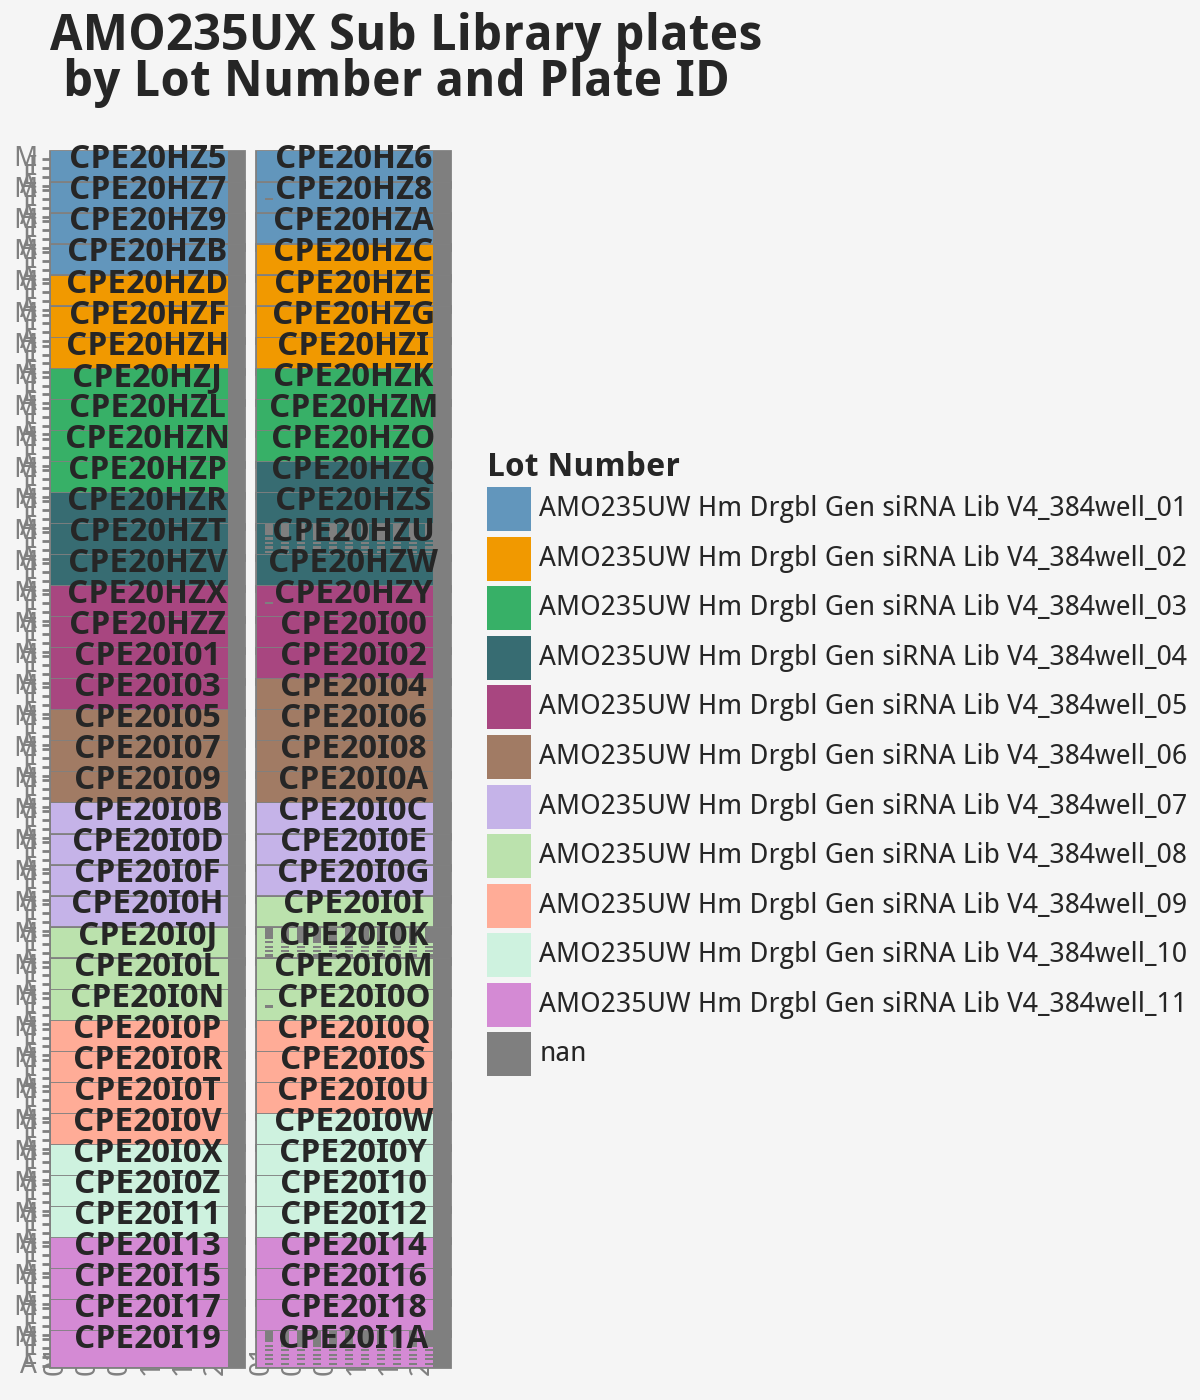

<Figure Size: (600 x 700)>

In [26]:
plot_data = wg_siRNA[wg_siRNA['Sub Library'] == 'Drgbl Gen']
plot_data['Lot Number'] = plot_data['Lot Number'].str.replace('_Sil Sel ', ' ').str.replace(' Ext Set V4_384well_', '_').str.replace('4392423_', '')
plot_data['Lot Number'][plot_data['Amount'].isna()] = np.nan

(ggplot(plot_data) +
      aes(x = 'Col', y = 'Row', fill = 'Lot Number') +
      geom_tile() +
      scale_fill_manual(values = utl.mode20b[4:]) + 
      scale_y_discrete(breaks = list(wg_siRNA['Row'].unique())[0::4]) +
      scale_x_discrete(breaks = list(wg_siRNA['Col'].unique())[0::4]) +
      ggtitle('AMO235UX Sub Library plates \n by Lot Number and Plate ID') +
      #facet_wrap('Plate ID', ncol = 7) + 
      facet_wrap('Plate ID', ncol = 2) + 
      utl.style +
      theme(# @figure_size = [10, 12], 
            figure_size = [6, 7], 
            strip_text = element_text(size = 12),
            legend_position = 'right',
            axis_text_x = element_text(angle = 90),
            axis_title = element_blank())
 )

In [40]:
wg_siRNA['Gene ID'].nunique()

21505

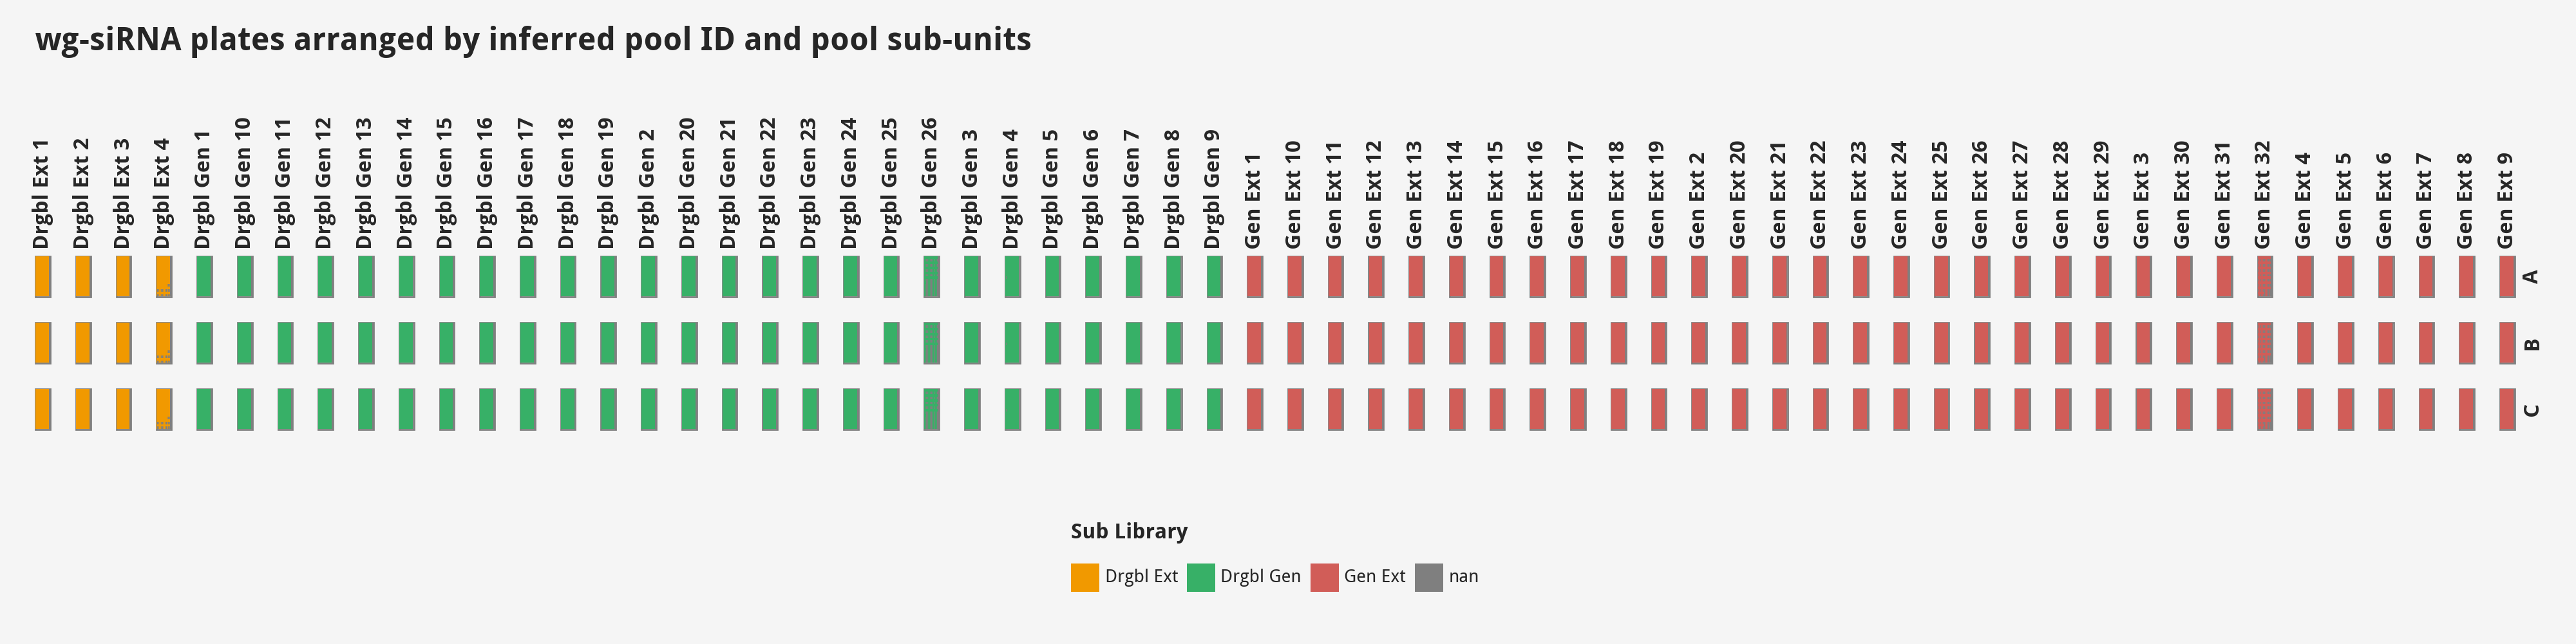

<Figure Size: (2000 x 500)>

In [43]:

plot_data = wg_siRNA
plot_data['Sub Library'][plot_data['Amount'].isna()] = np.nan

(ggplot(plot_data) +
      aes(x = 'Col', y = 'Row', fill = 'Sub Library') +
      geom_tile() +
      scale_fill_manual(values = utl.mode20[1:]) + 
      scale_y_discrete(breaks = list(wg_siRNA['Row'].unique())[0::4]) +
      scale_x_discrete(breaks = list(wg_siRNA['Col'].unique())[0::4]) +
      ggtitle('wg-siRNA plates arranged by inferred pool ID and pool sub-units') +
      #facet_wrap('Plate ID', ncol = 7) + 
      facet_grid(facets = ['pool unit', 'pool ID']) +  # type: ignore
      utl.style +
      theme(# text = element_text(family = 'Lato'), 
            # figure_size = [10, 12], 
            figure_size = [20, 5], 
            strip_text = element_text(size = 12, rotation = 90, ha = 'left'),
            legend_position = 'bottom',
            axis_text = element_blank(),
            axis_ticks = element_blank(),
            #axis_text_x = element_text(angle = 90),
            axis_title = element_blank())
 )

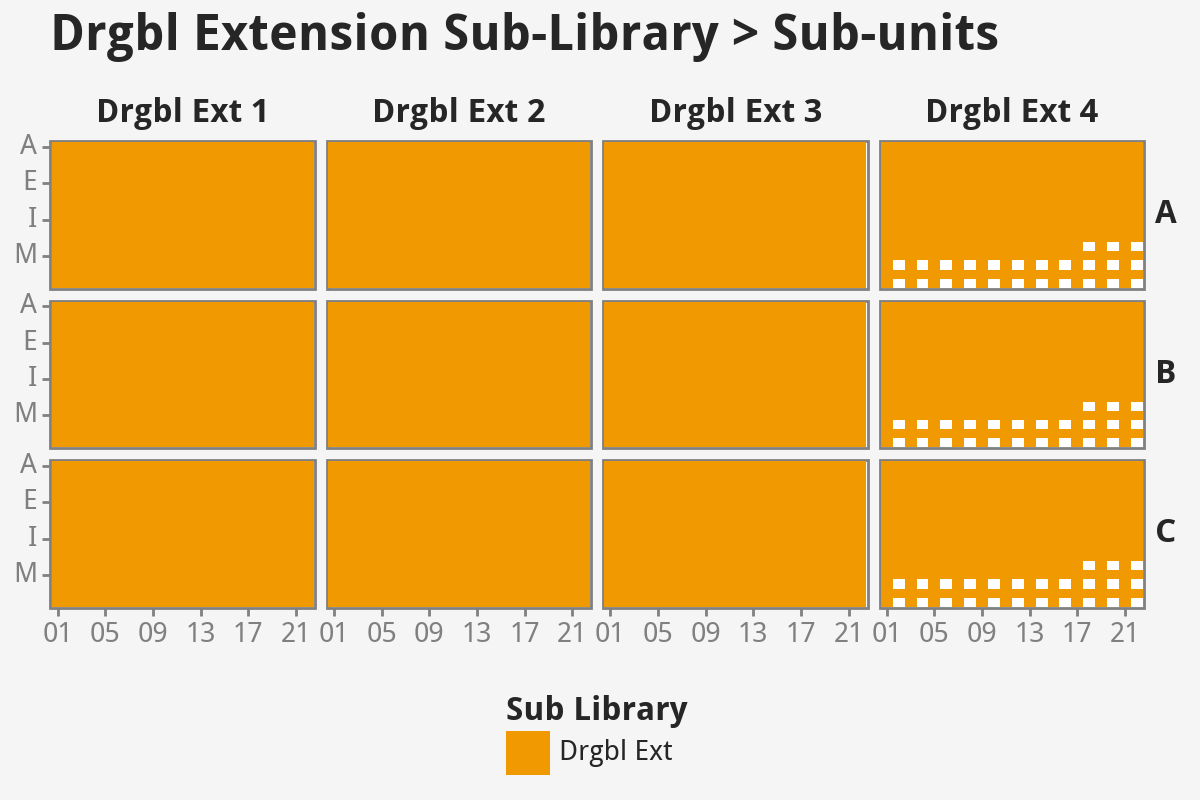

<Figure Size: (600 x 400)>

In [50]:
plot_data = wg_siRNA[wg_siRNA['Sub Library'] == 'Drgbl Ext']
plot_data['Sub Library'][plot_data['Amount'].isna()] = np.nan

(ggplot(plot_data) +
      aes(x = 'Col', y = 'Row', fill = 'Sub Library') +
      geom_tile() +
      scale_fill_manual(values = utl.mode20[1:]) + 
      scale_y_discrete(breaks = list(wg_siRNA['Row'].unique())[0::4]) +
      scale_x_discrete(breaks = list(wg_siRNA['Col'].unique())[0::4]) +
      ggtitle('Drgbl Extension Sub-Library > Sub-units') +
      #facet_wrap('Plate ID', ncol = 7) + 
      facet_grid(facets = ['pool unit', 'pool ID']) +  # type: ignore
      utl.style +
      theme(# text = element_text(family = 'Lato'), 
            # figure_size = [10, 12], 
            figure_size = [6, 4], 
            strip_text = element_text(size = 12, rotation = 0, ha = 'left'),
            legend_position = 'bottom',
            #axis_text = element_blank(),
            #axis_ticks = element_blank(),
            #axis_text_x = element_text(angle = 90),
            axis_title = element_blank())
 )

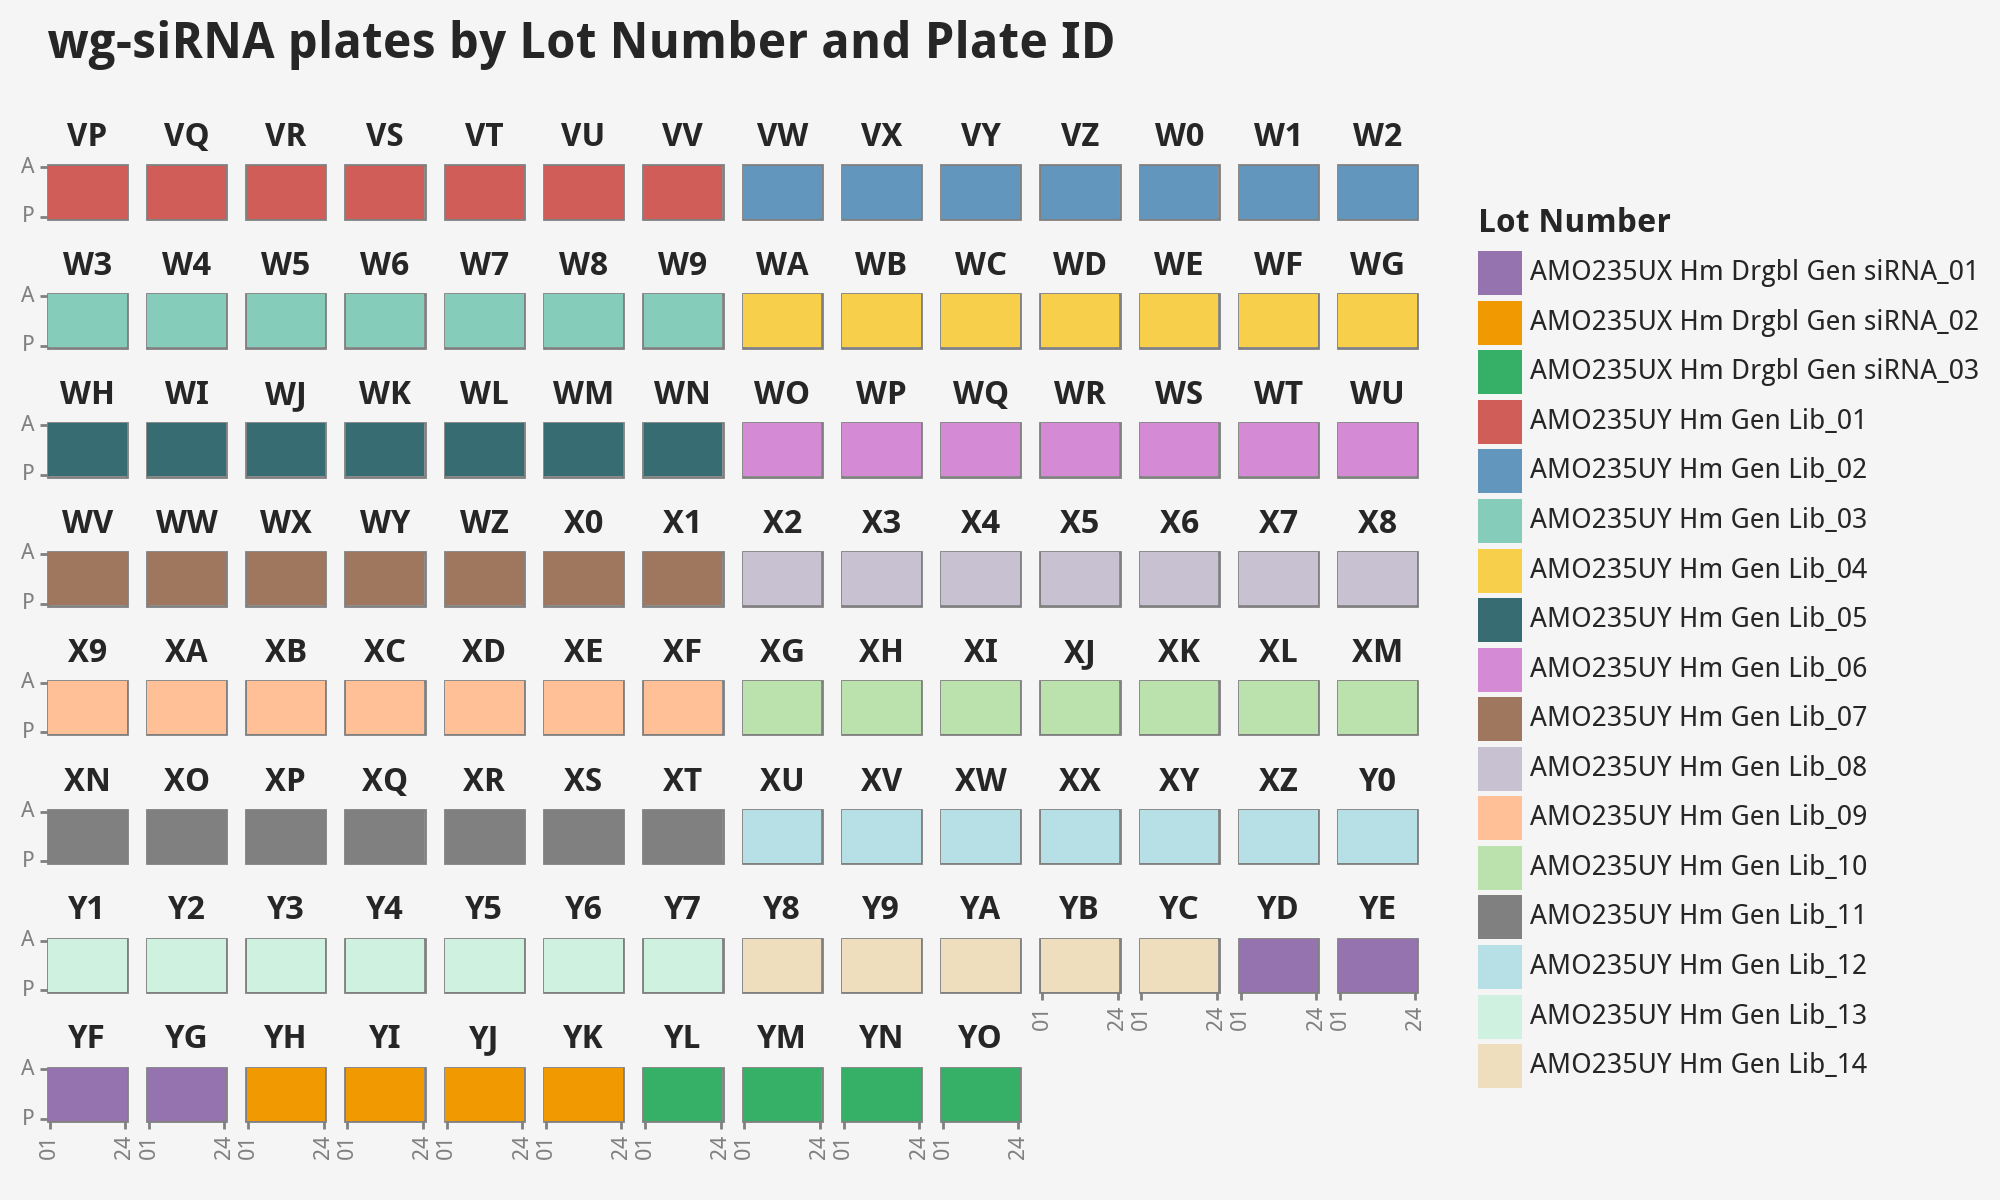

<Figure Size: (1000 x 600)>

In [79]:
plot_data = wg_siRNA
plot_data['Lot Number'] = plot_data['Lot Number'].str.replace('_Sil Sel ', ' ').str.replace(' Ext Set V4_384well_', '_').str.replace('4392423_', '')

(ggplot(plot_data) +
      aes(x = 'Col', y = 'Row', fill = 'Lot Number') +
      geom_tile() +
      scale_fill_manual(values = utl.mode20) + 
      scale_y_discrete(breaks = list(wg_siRNA['Row'].unique())[0::15]) +
      scale_x_discrete(breaks = list(wg_siRNA['Col'].unique())[0::23]) +
      ggtitle('wg-siRNA plates by Lot Number and Plate ID') +
      #facet_wrap('Plate ID', ncol = 7) + 
      facet_wrap('P#', ncol = 14) + 
      utl.style +
      theme(# text = element_text(family = 'Lato'), 
            # @figure_size = [10, 12], 
            figure_size = [10, 6], 
            strip_text = element_text(size = 12),
            legend_position = 'right',
            axis_text = element_text(size = 8),
            axis_text_x = element_text(angle = 90),
            axis_title = element_blank())
 )

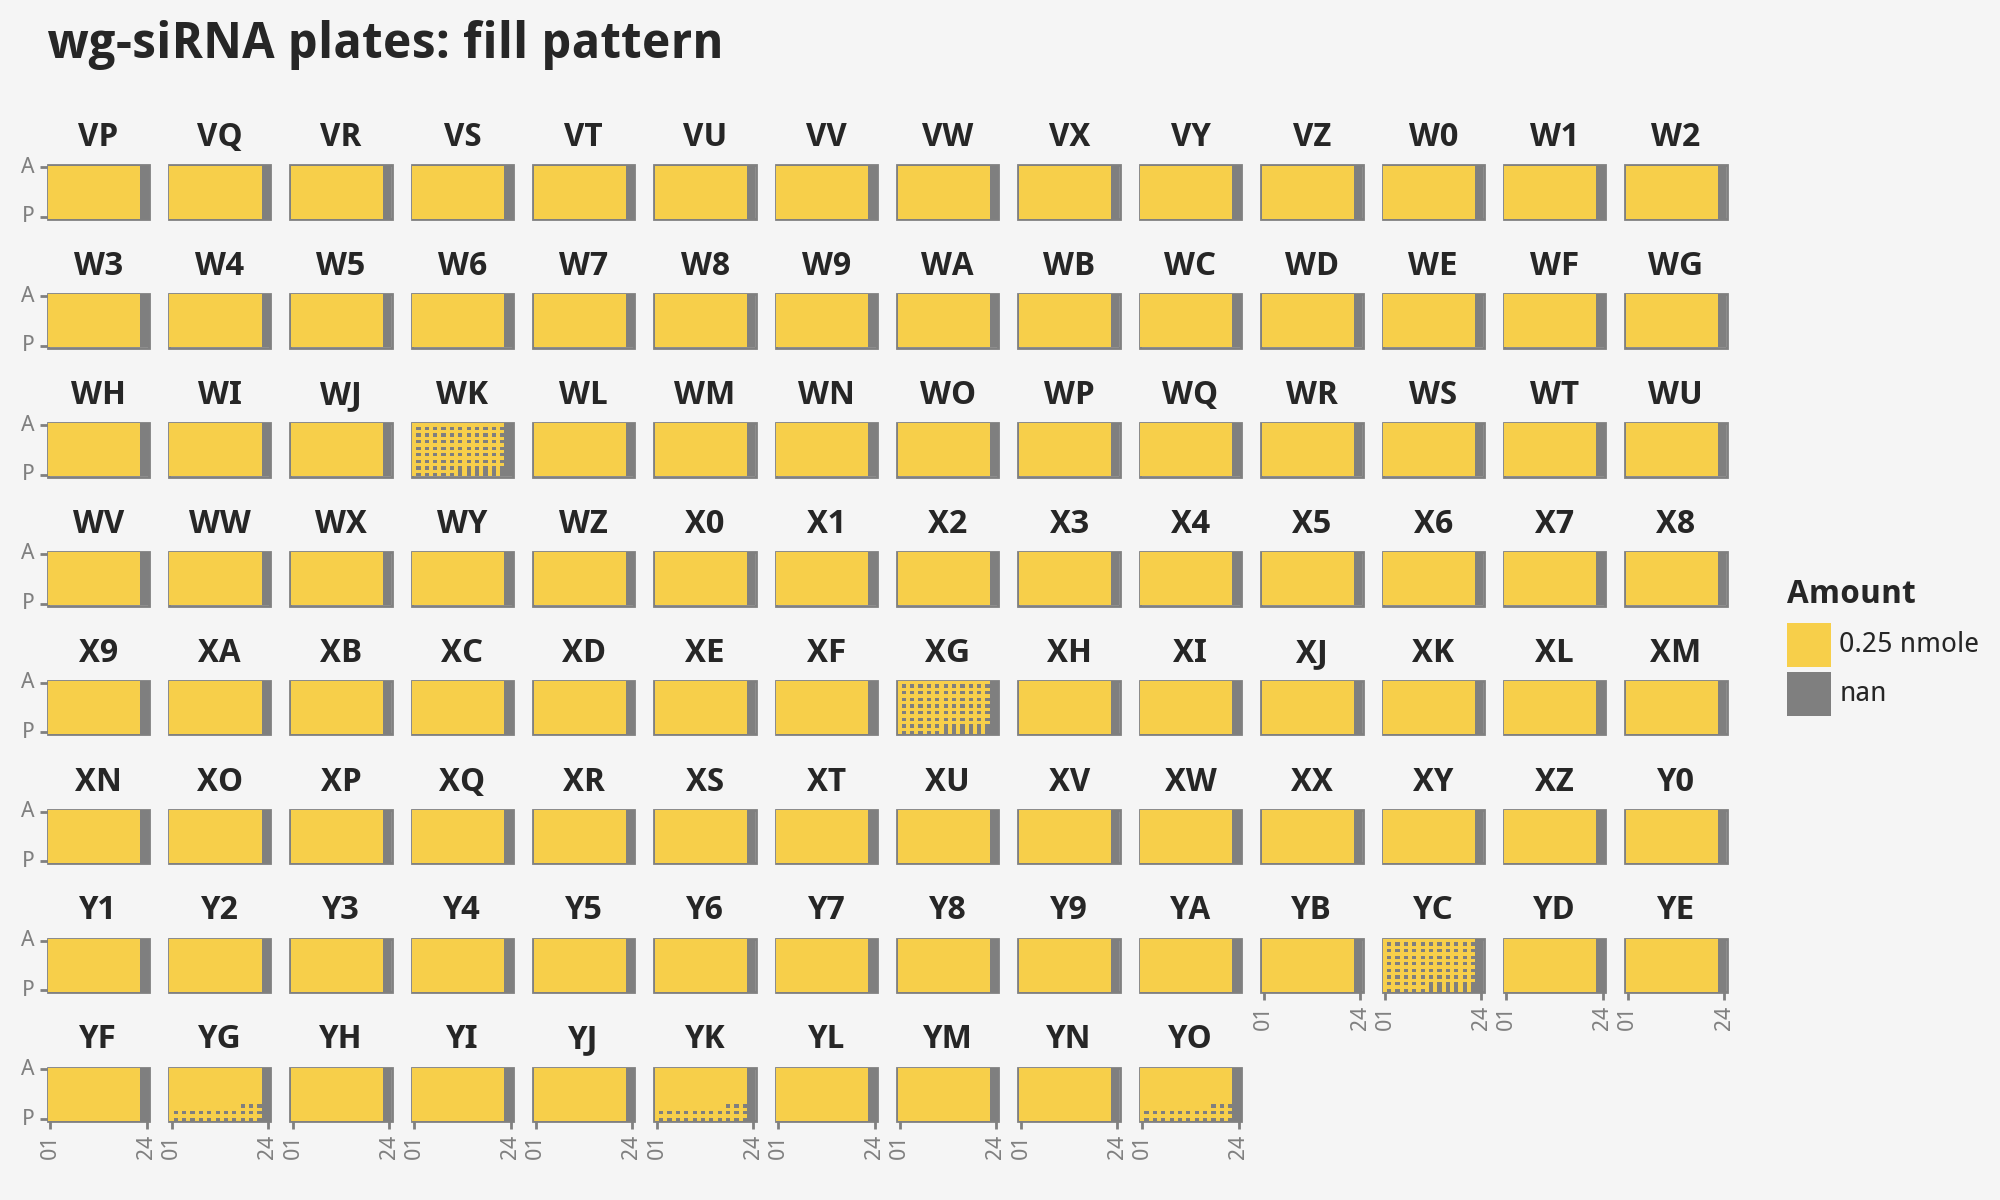

<Figure Size: (1000 x 600)>

In [78]:
(ggplot(plot_data) +
      aes(x = 'Col', y = 'Row', fill = 'Amount') +
      geom_tile() +
      scale_fill_manual(values = utl.mode20b[1]) + 
      scale_y_discrete(breaks = list(wg_siRNA['Row'].unique())[0::15]) +
      scale_x_discrete(breaks = list(wg_siRNA['Col'].unique())[0::23]) +
      ggtitle('wg-siRNA plates: fill pattern') +
      #facet_wrap('Plate ID', ncol = 7) + 
      facet_wrap('P#', ncol = 14) + 
      utl.style +
      theme(# text = element_text(family = 'Lato'), 
            # figure_size = [10, 12], 
            figure_size = [10, 6], 
            strip_text = element_text(size = 12),
            legend_position = 'right',
            axis_text = element_text(size = 8),
            axis_text_x = element_text(angle = 90),
            axis_title = element_blank())
 )

In [83]:
df = pd.DataFrame(wg_siRNA[wg_siRNA['Gene Symbol'] != 'Empty Well'].apply(lambda x: x.nunique()))#.reset_index()
df.columns = ['n_unique']
df.sort_values('n_unique', ascending = False)

,n_unique
Sample ID,37659
siRNA ID,37659
Antisense siRNA Sequence,37635
Sense siRNA Sequence,37631
RefSeq Accession Number,12844
Gene Symbol,12683
Gene ID,12488
Full Gene Name,12407
Exon(s) Targeted,574
Location (Row-Col),352


In [128]:
df = wg_siRNA
# Specify the column for which you want to find duplicates
column_name = 'Gene Symbol'

# Use duplicated() to find duplicates in the specified column
duplicates_mask = df[column_name].duplicated(keep=False)

# Use boolean indexing to get the duplicate values and their counts
duplicates = df[column_name][duplicates_mask]
duplicate_counts = duplicates.value_counts()

# Print the duplicate values and their counts
#print("Duplicate values in column '{}' and their counts:".format(column_name))
#print(duplicates)
print("Counts:")
print(duplicate_counts)

Counts:
Gene Symbol
ALG13        9
SETD3        6
ASCL5        6
C6orf132     6
ROPN1L       6
            ..
LINC00977    2
LOC653712    2
LOC729464    2
CEP27        2
C12orf67     2
Name: count, Length: 10453, dtype: int64
